# Fake News Detection- 2
Fake News Detection using NLP and different classifers approach

### The main aim of this project is to detect whether the news is Real or Fake using proper text extraction techniques and combining them with different machine learning classifiers to make detections on the test set

In [1]:
import numpy as np 
import pandas as pd

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import itertools

import nltk
import seaborn  as sns
import re
from nltk.corpus import stopwords

import tensorflow as tf
print(tf.__version__)

import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt

import pickle

2.11.0


### Loading datasets

In [3]:
train_df = pd.read_csv('../DataSets/train.csv')
test_df =   pd.read_csv('../DataSets/test.csv')

In [4]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
test_df.head

<bound method NDFrame.head of          id                                              title  \
0     20800  Specter of Trump Loosens Tongues, if Not Purse...   
1     20801  Russian warships ready to strike terrorists ne...   
2     20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3     20803  Tim Tebow Will Attempt Another Comeback, This ...   
4     20804                    Keiser Report: Meme Wars (E995)   
...     ...                                                ...   
5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
5197  25997  California Today: What, Exactly, Is in Your Su...   
5198  25998  300 US Marines To Be Deployed To Russian Borde...   
5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1                         NaN   
2               Common Dreams   
3               Daniel Victor   
4     Truth 

In [6]:
test_df.shape

(5200, 4)

In [7]:
train_df.shape

(20800, 5)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


### Handling null values

In [9]:
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [10]:
train_df.dtypes.value_counts()

object    3
int64     2
dtype: int64

### Concatenating the title, the author and the main text to make the model more generalised and increasing the reliability of the model

In [11]:
train_df=train_df.fillna(' ')

In [12]:
train_df['total']=train_df['title']+' '+train_df['author']+' '+train_df['text']
test_df['total']=test_df['title']+' '+test_df['author']+' '+test_df['text']

In [13]:
train_df.head

<bound method NDFrame.head of           id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2        

In [14]:
test_df.head

<bound method NDFrame.head of          id                                              title  \
0     20800  Specter of Trump Loosens Tongues, if Not Purse...   
1     20801  Russian warships ready to strike terrorists ne...   
2     20802  #NoDAPL: Native American Leaders Vow to Stay A...   
3     20803  Tim Tebow Will Attempt Another Comeback, This ...   
4     20804                    Keiser Report: Meme Wars (E995)   
...     ...                                                ...   
5195  25995  The Bangladeshi Traffic Jam That Never Ends - ...   
5196  25996  John Kasich Signs One Abortion Bill in Ohio bu...   
5197  25997  California Today: What, Exactly, Is in Your Su...   
5198  25998  300 US Marines To Be Deployed To Russian Borde...   
5199  25999  Awkward Sex, Onscreen and Off - The New York T...   

                       author  \
0            David Streitfeld   
1                         NaN   
2               Common Dreams   
3               Daniel Victor   
4     Truth 

### Splitting the data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df['total'], train_df.label, test_size=0.20, random_state=0)

## Count Vectorizer

### CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [16]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

## Tf-IDF Vectorizer

### TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.



In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

#### Defining the function to build the confusion matrix

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## Using Different ML models with Count Vectorizer and TF-IDF Vectorizer

### Logistic Regression with CountVectorizer

0.9776442307692308


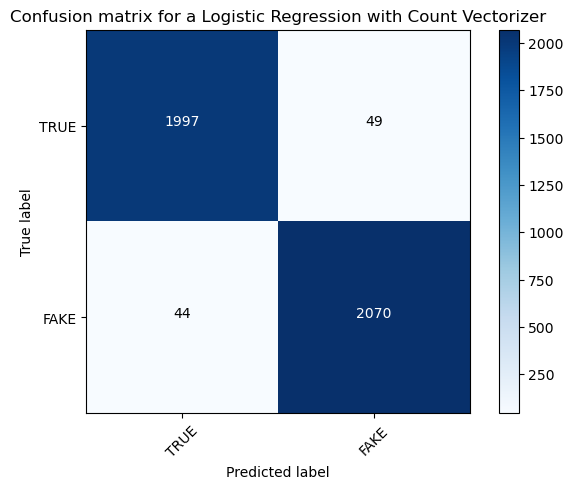

In [19]:
logreg = LogisticRegression(C=1e5)
logreg.fit(count_train, y_train)
pred_logreg_count = logreg.predict(count_test)
acc_logreg_count = metrics.accuracy_score(y_test,pred_logreg_count)
print(acc_logreg_count)
cm3 = metrics.confusion_matrix(y_test, pred_logreg_count, labels=[0,1])
plot_confusion_matrix(cm3, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Count Vectorizer')

### Model Accuracy: 97.7%

#### News that are real and predicted real (TP) : 1997
#### News that are real but predicted fake (FN) : 49
#### News that are fake but predicted real (FP) : 44
#### News that are fake and predicted fake (TN) : 2070

### Logistic Regression with TF-IDF Vectorizer

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9800480769230769


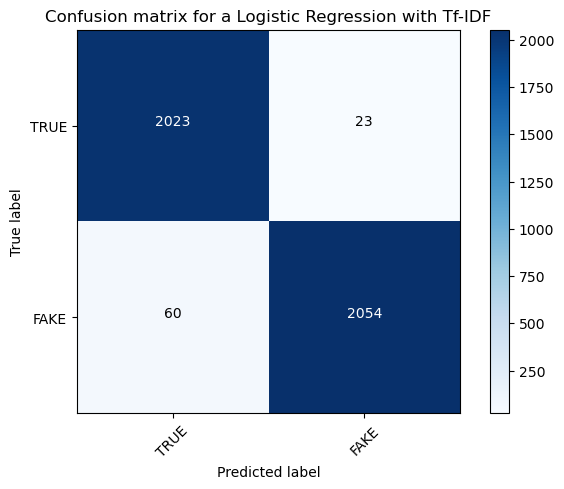

In [20]:
logreg = LogisticRegression(C=1e5)
logreg.fit(tfidf_train, y_train)
pred_logreg_tfidf = logreg.predict(tfidf_test)
pred_logreg_tfidf_proba = logreg.predict_proba(tfidf_test)[:,1]
acc_logreg_tfidf = metrics.accuracy_score(y_test,pred_logreg_tfidf)
print(acc_logreg_tfidf)
cm4 = metrics.confusion_matrix(y_test, pred_logreg_tfidf, labels=[0,1])
plot_confusion_matrix(cm4, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Tf-IDF')

### Model Accuracy: 98.0%

#### News that are real and predicted real (TP) : 2023
#### News that are real but predicted fake (FN) : 23
#### News that are fake but predicted real (FP) : 59
#### News that are fake and predicted fake (TN) : 2055

### Multinomial Naive Bayes with Count Vectorizer

In [21]:
nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
acc_nb_count = metrics.accuracy_score(y_test, pred_nb_count)
print(acc_nb_count)

0.942548076923077


###### Tuning the hyperparameter alpha

In [22]:
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train, y_train)
    pred_tune = nb_classifier_tune.predict(count_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.00 Score: 0.91106
Alpha: 0.05 Score: 0.94183
Alpha: 0.10 Score: 0.94255
Alpha: 0.15 Score: 0.94279
Alpha: 0.20 Score: 0.94231
Alpha: 0.25 Score: 0.94111
Alpha: 0.30 Score: 0.93990
Alpha: 0.35 Score: 0.93822
Alpha: 0.40 Score: 0.93750
Alpha: 0.45 Score: 0.93630
Alpha: 0.50 Score: 0.93510
Alpha: 0.55 Score: 0.93486
Alpha: 0.60 Score: 0.93341
Alpha: 0.65 Score: 0.93149
Alpha: 0.70 Score: 0.93029
Alpha: 0.75 Score: 0.92909
Alpha: 0.80 Score: 0.92788
Alpha: 0.85 Score: 0.92644
Alpha: 0.90 Score: 0.92428
Alpha: 0.95 Score: 0.92308


###### Trying with the finetuned model again

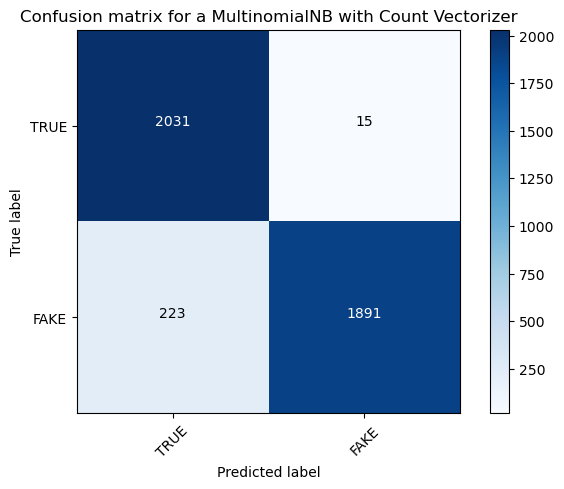

In [23]:
nb_classifier = MultinomialNB(alpha = 0.15)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
cm = metrics.confusion_matrix(y_test, pred_nb_count, labels=[0,1])    
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Count Vectorizer')

### Model Accuracy: 92.3%

#### News that are real and predicted real (TP) : 2031
#### News that are real but predicted fake (FN) : 15
#### News that are fake but predicted real (FP) : 223
#### News that are fake and predicted fake (TN) : 1891

### Multinomial Naive Bayes with TF-IDF Vectorizer

In [24]:
nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
acc_nb_tfidf = metrics.accuracy_score(y_test, pred_nb_tfidf)
print(acc_nb_tfidf)

0.926923076923077


###### Tuning the hyperparameter alpha

In [25]:
for alpha in np.arange(0,0.1,.01):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(tfidf_train, y_train)
    pred_tune = nb_classifier_tune.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.00  Score: 0.90649
Alpha: 0.01  Score: 0.94375
Alpha: 0.02  Score: 0.94375
Alpha: 0.03  Score: 0.94159
Alpha: 0.04  Score: 0.93966
Alpha: 0.05  Score: 0.93822
Alpha: 0.06  Score: 0.93462
Alpha: 0.07  Score: 0.93317
Alpha: 0.08  Score: 0.93005
Alpha: 0.09  Score: 0.92861


##### Trying with the finetuned model again

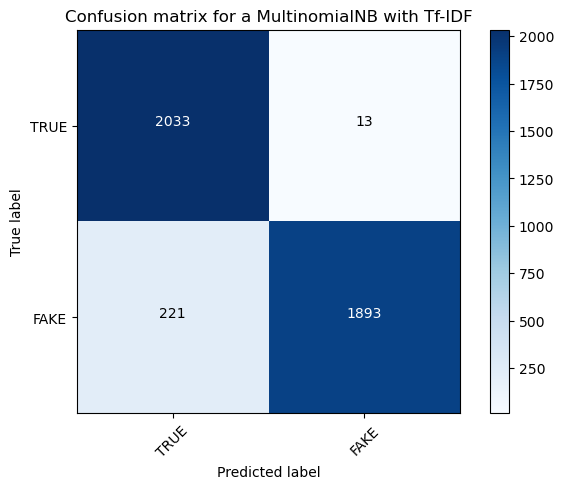

In [26]:
nb_classifier = MultinomialNB(alpha = 0.01)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
cm2 = metrics.confusion_matrix(y_test, pred_nb_tfidf, labels=[0,1])
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Tf-IDF')

### Model Accuracy: 92.8%

#### News that are real and predicted real (TP) : 2033
#### News that are real but predicted fake (FN) : 13
#### News that are fake but predicted real (FP) : 221
#### News that are fake and predicted fake (TN) : 1893

### Passive Agressive Classifier With Count Vectorizer

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9670673076923076


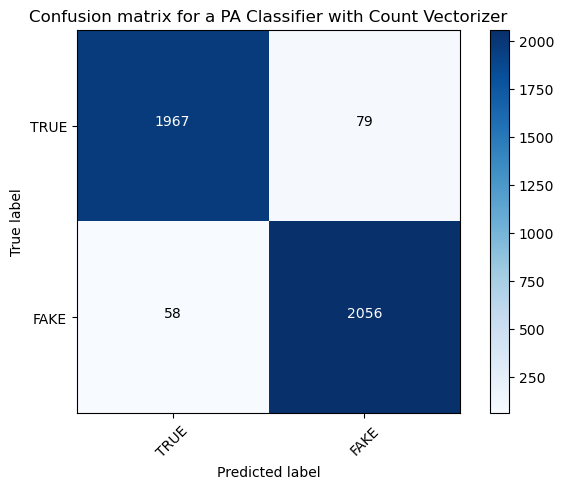

In [27]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
linear_classifier.fit(count_train, y_train)
pred_linear_count = linear_classifier.predict(count_test)
acc_linear_count = metrics.accuracy_score(y_test, pred_linear_count)
print(acc_linear_count)
cm6 = metrics.confusion_matrix(y_test, pred_linear_count, labels=[0,1])
plot_confusion_matrix(cm6, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Count Vectorizer')

### Model Accuracy: 96.8%

#### News that are real and predicted real (TP) : 1970
#### News that are real but predicted fake (FN) : 76
#### News that are fake but predicted real (FP) : 55
#### News that are fake and predicted fake (TN) : 1893

### Passive Agressive Classifier With TF-IDF Vectorizer

0.9795673076923077


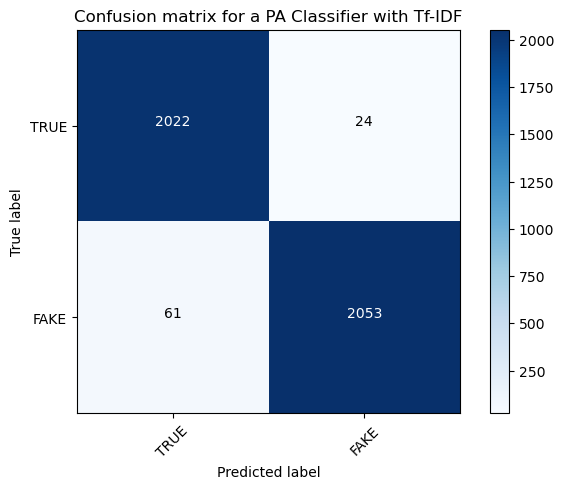

In [28]:
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
linear_classifier.fit(tfidf_train, y_train)
pred_linear_tfidf = linear_classifier.predict(tfidf_test)
acc_linear_tfidf = metrics.accuracy_score(y_test, pred_linear_tfidf)
print(acc_linear_tfidf)
cm5 = metrics.confusion_matrix(y_test, pred_linear_tfidf, labels=[0,1])
plot_confusion_matrix(cm5, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Tf-IDF')

### Model Accuracy: 98.0%

#### News that are real and predicted real (TP) : 2025
#### News that are real but predicted fake (FN) : 21
#### News that are fake but predicted real (FP) : 59
#### News that are fake and predicted fake (TN) : 2055

# LTSM Networks

In [29]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
ltsm_train_df = pd.read_csv(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Fake News Detection\Dataset/train.csv')
ltsm_test_df =   pd.read_csv(r'C:\Users\KIIT\Documents\LGM-Soc contributions\Fake News Detection\Dataset/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KIIT\\Documents\\LGM-Soc contributions\\Fake News Detection\\Dataset/train.csv'

In [ ]:
ltsm_train_df.dropna(inplace=True)
ltsm_test_df.dropna(inplace=True)

In [ ]:
sns.countplot(ltsm_train_df['label'])

In [ ]:
X_train=ltsm_train_df.drop('label', axis=1)
X_train

In [ ]:
X_train.shape

In [ ]:
y_train=ltsm_train_df['label']
y_train

In [ ]:
y_train.shape

In [ ]:
X_train.reset_index(inplace=True)

## Data Preprocessing
   ### - Preprocessing the text, removing all the other characters, converting it to lower cases, and removing the stop words
   ### - Converting the title one hot encoding
   ### - Adding a padding to bring the sentences to a common length

In [ ]:
def remove_stop_words(X):
    corpus=[]
    ps=PorterStemmer()   
    for i in range(len(X.index)):
        sent= re.sub('[^a-zA-Z]', ' ', X['title'][i])
        sent= sent.lower()
        sent= sent.split()
        sent= [ps.stem(word) for word in sent if word not in set(stopwords.words('english'))]
        sent= ' '.join(sent)
        corpus.append(sent)
    return corpus

In [ ]:
corpus=[]
test_corpus=[]

corpus=remove_stop_words(X_train)

In [ ]:
corpus[0:3]
len(corpus)

In [ ]:
voc_size=10000
onehot=[one_hot(word, voc_size) for word in corpus]
max_seq_size=25
embadding=pad_sequences(onehot,maxlen=max_seq_size,padding='pre')
embadding

In [ ]:
X_train=np.array(embadding)
y_train=np.array(y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

##### Adding model layers

In [ ]:
def create_model():
    output_dim=45
    model=Sequential()
    model.add(Embedding(voc_size,output_dim, input_length=max_seq_size))
    model.add(Dropout(0.25))
    model.add(LSTM(200))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [ ]:
ltsm_model = create_model()

In [ ]:
ltsm_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
ltsm_model.summary()

#### Training the LTSM model

In [ ]:
history=ltsm_model.fit(X_train,y_train, epochs=30, validation_data=(X_test, y_test),batch_size=16)

### Visualizing the training loss and testing loss 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Making Predictions

In [ ]:
train_preds = ltsm_model.predict_classes(y_test)
train_preds

In [ ]:
print(f"Confusion matrix  \n {confusion_matrix(train_preds,y_test)}")

#### From the confusion matric we can understand that the model has predicted 2379 actually Real news as Real and 3107 actually Fake news as Fake. 

In [ ]:
ltsm_model.save('ltsm_model.h5')